# Initial Setup and Data Loading


In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Load the preprocessed data
processed_data = pd.read_parquet("/mnt/c/Users/Florian/Desktop/Uni/MSc/FoPr/preprocessed_pcp_data.parquet")
processed_data.head()
processed_data.info()
print(f"Total number of data points: {len(processed_data)}")

<class 'pandas.core.frame.DataFrame'>
Index: 757820 entries, 0 to 758525
Data columns (total 10 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   modified_sequence                  757820 non-null  object 
 1   precursor_charge                   757820 non-null  object 
 2   precursor_intensity                757820 non-null  object 
 3   charge_by_max_intensity            757820 non-null  int64  
 4   max_intensity                      757820 non-null  float64
 5   charge_by_avg_intensity            757820 non-null  int64  
 6   avg_intensity                      757820 non-null  float64
 7   one_hot_most_abundant_charge       757820 non-null  object 
 8   charge_state_vector                757820 non-null  object 
 9   normalized_intensity_distribution  757820 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 63.6+ MB
Total number of data points: 757820


## Data Preparation for Task 1

Here we split the data into training, validation, and test sets, ensuring that the splits are stratified by the `charge_by_max_intensity` to maintain distribution consistency across datasets.



Train Set Relative Distribution:
charge_by_max_intensity
2    52.579548
3    34.693155
4     7.359047
1     4.505028
5     0.800322
6     0.062900
Name: proportion, dtype: float64

Validation Set Relative Distribution:
charge_by_max_intensity
2    52.579108
3    34.692935
4     7.359267
1     4.505028
5     0.800322
6     0.063340
Name: proportion, dtype: float64

Test Set Relative Distribution:
charge_by_max_intensity
2    52.579108
3    34.693595
4     7.359267
1     4.505028
5     0.800322
6     0.062680
Name: proportion, dtype: float64


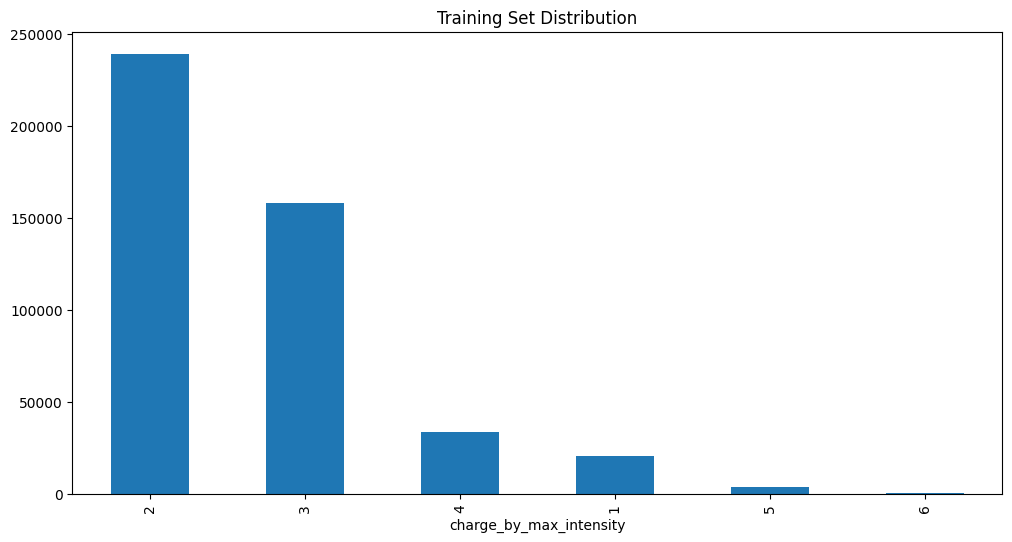

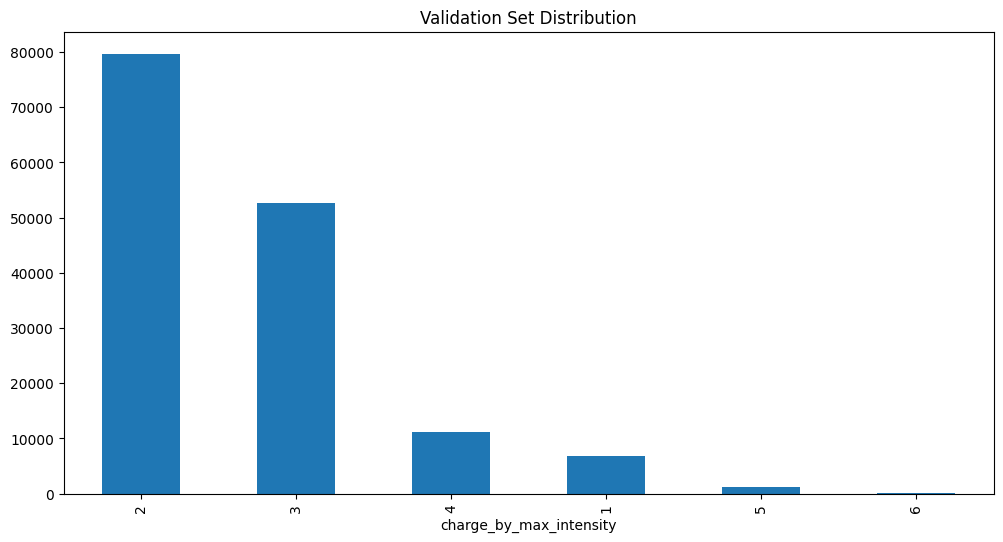

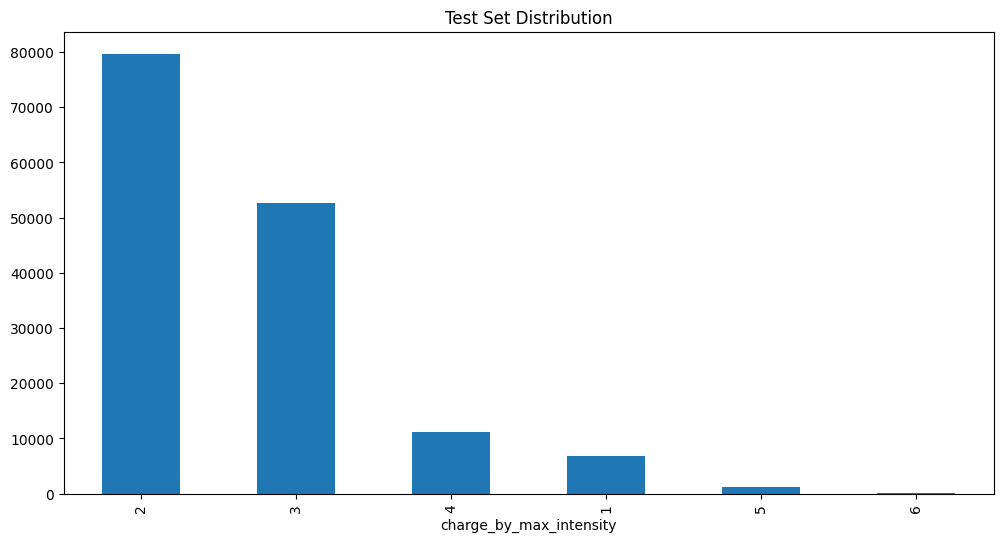

In [3]:
# Copying data to avoid modification of the original dataframe
df = processed_data.copy()

# Stratified split to maintain distribution of charge_by_max_intensity
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['charge_by_max_intensity'])
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df['charge_by_max_intensity'])  # Further split to create validation set

# Function to calculate and display relative distribution of charge states
def calculate_relative_distribution(dataframe):
    distribution = dataframe['charge_by_max_intensity'].value_counts(normalize=True)
    return distribution * 100

# Displaying relative distribution of charge states in each set
print("\nTrain Set Relative Distribution:")
print(calculate_relative_distribution(train_df))
print("\nValidation Set Relative Distribution:")
print(calculate_relative_distribution(val_df))
print("\nTest Set Relative Distribution:")
print(calculate_relative_distribution(test_df))

# Plot distribution for training, validation, and test sets
def plot_distribution(dataframe, title):
    plt.figure(figsize=(12, 6))
    dataframe['charge_by_max_intensity'].value_counts().plot(kind='bar')
    plt.title(title)
    plt.show()

plot_distribution(train_df, 'Training Set Distribution')
plot_distribution(val_df, 'Validation Set Distribution')
plot_distribution(test_df, 'Test Set Distribution')


## Task 2


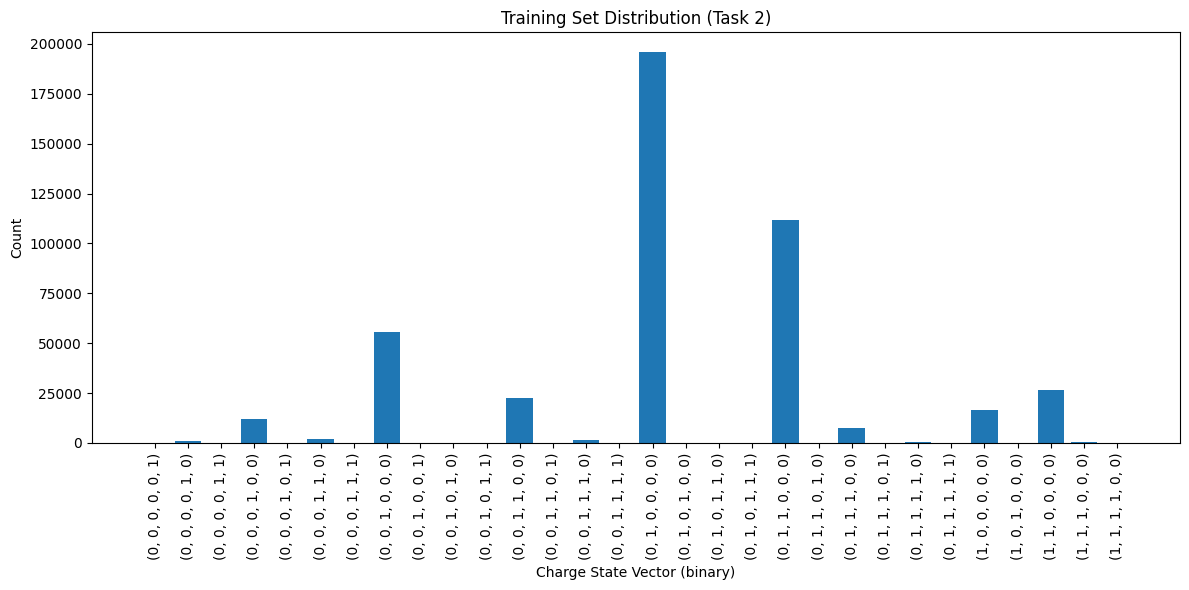

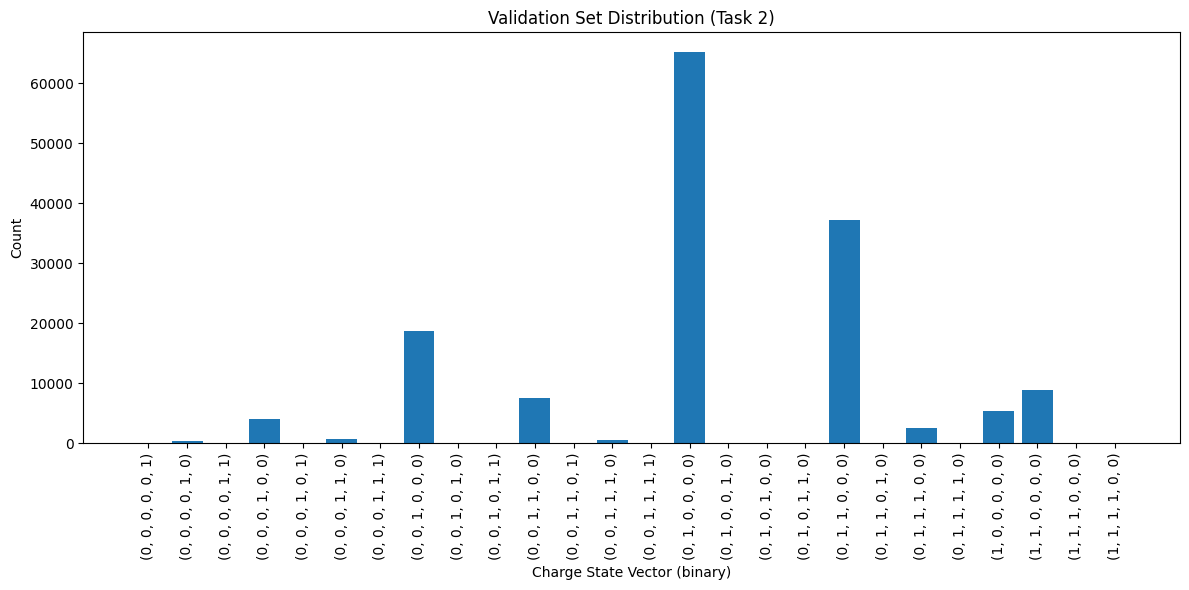

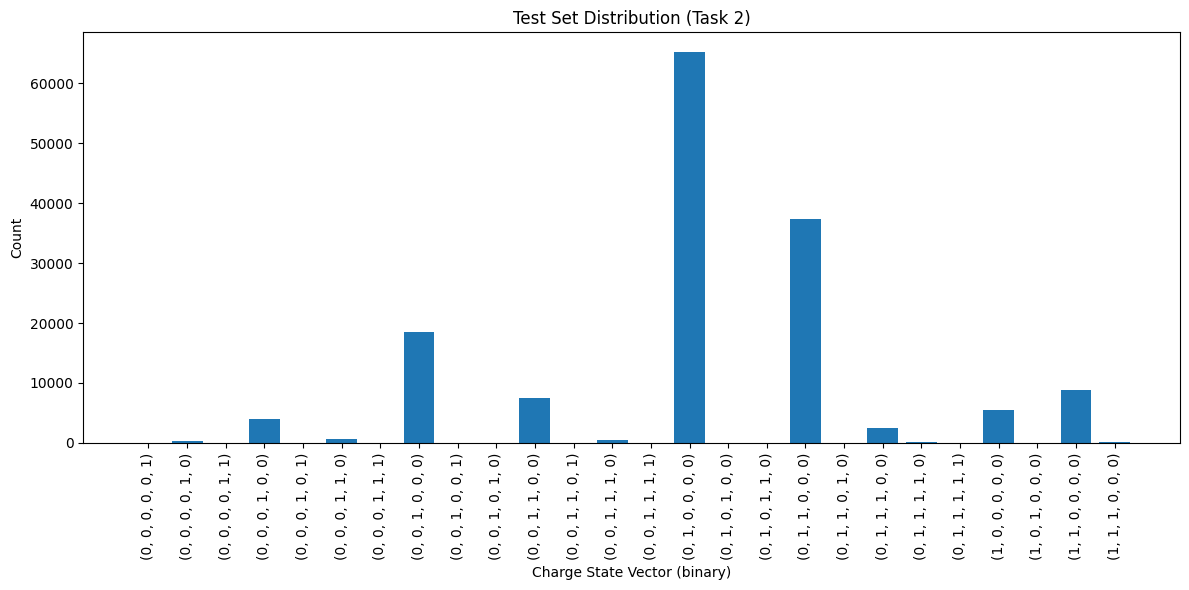

In [4]:
import ast
from collections import Counter

# Helper function to convert string representations to list
def literal_eval_list(col):
    return [int(x) for x in ast.literal_eval(col)]

# Function to count unique combinations of charge states
def count_charge_states(df, col):
    tuples = df[col].apply(lambda x: tuple(x))
    return Counter(tuples)

# Function to plot distribution with labels
def plot_distribution_with_labels(counter, title):
    labels, counts = zip(*sorted(counter.items()))
    label_strings = [str(label) for label in labels]
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(counts)), counts, tick_label=label_strings)
    plt.xlabel("Charge State Vector (binary)")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Counting and plotting distributions
train_counter = count_charge_states(train_df, 'charge_state_vector')
val_counter = count_charge_states(val_df, 'charge_state_vector')
test_counter = count_charge_states(test_df, 'charge_state_vector')

plot_distribution_with_labels(train_counter, "Training Set Distribution (Task 2)")
plot_distribution_with_labels(val_counter, "Validation Set Distribution (Task 2)")
plot_distribution_with_labels(test_counter, "Test Set Distribution (Task 2)")

In [6]:
# show which classes are missing in the validation set
missing_classes = set(train_counter.keys()) - set(val_counter.keys())
print("Missing classes in validation set:")
for missing_class in missing_classes:
    print(missing_class)
# show which classes are missing in the test set
missing_classes = set(train_counter.keys()) - set(test_counter.keys())
print("Missing classes in test set:")
for missing_class in missing_classes:
    print(missing_class)

Missing classes in validation set:
(0, 0, 1, 0, 0, 1)
(1, 0, 1, 0, 0, 0)
(0, 1, 1, 1, 0, 1)
(0, 1, 1, 1, 1, 1)
(0, 1, 0, 1, 1, 1)
Missing classes in test set:
(0, 1, 1, 1, 0, 1)
(1, 1, 1, 1, 0, 0)
(0, 1, 0, 1, 1, 1)
(0, 0, 1, 0, 1, 1)


## Analysis of Single vs Multiple Charge States


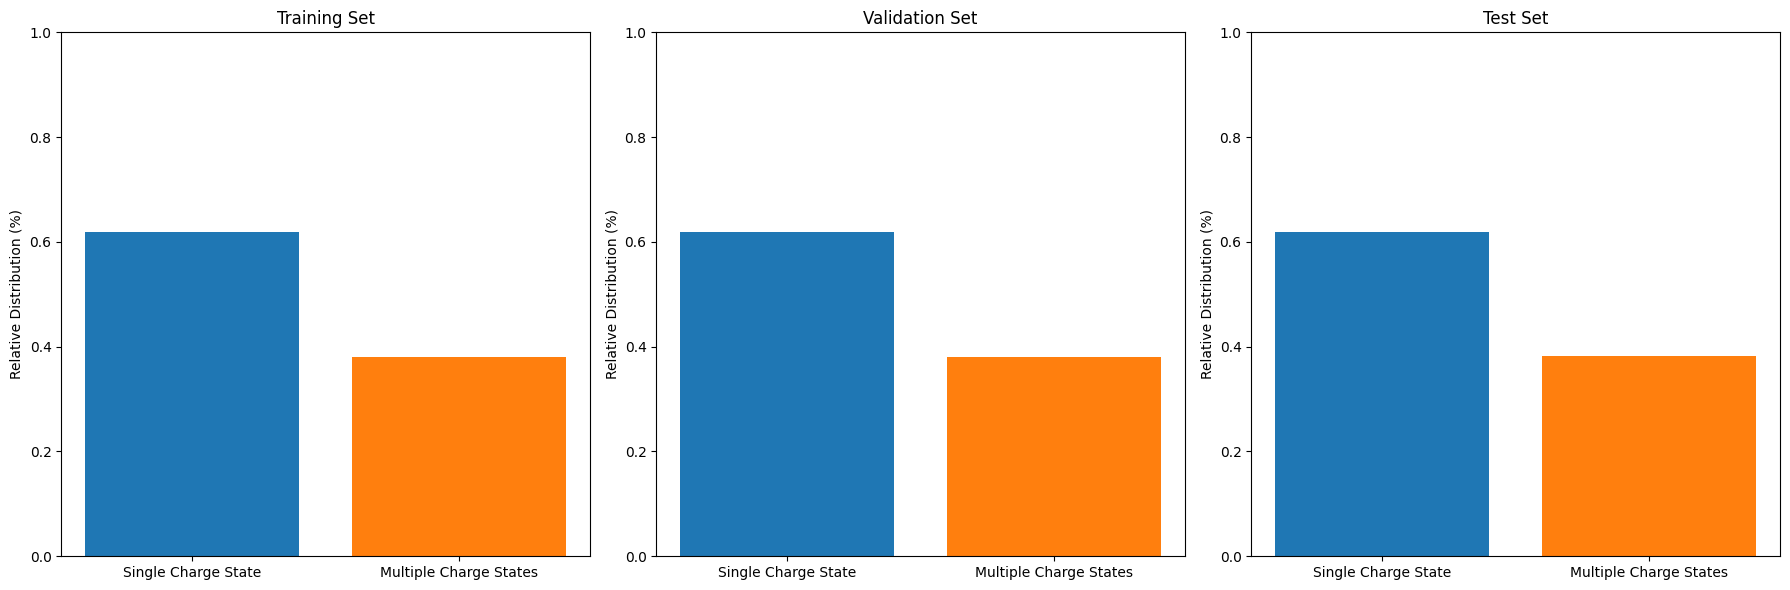

Training Set - Single: 281592 (61.93%), Multiple: 173100 (38.07%)
Validation Set - Single: 93774 (61.87%), Multiple: 57790 (38.13%)
Test Set - Single: 93697 (61.82%), Multiple: 57867 (38.18%)


In [7]:
def is_single_charge_state(vector):
    """
    Check if the vector represents a single charge state.
    Returns True if only one charge state is present, otherwise False.
    """
    return sum(vector) == 1

def count_and_relative_distribution(df, col):
    """
    Calculate the count and relative distribution of single vs multiple charge states.
    Returns counts and relative percentages of single and multiple charge states.
    """
    single_charge_state = df[col].apply(is_single_charge_state)
    single_count = single_charge_state.sum()
    multiple_count = len(df) - single_count
    
    total_count = len(df)
    single_relative = single_count / total_count
    multiple_relative = multiple_count / total_count
    
    return single_count, multiple_count, single_relative, multiple_relative

# Analyze charge state distributions in the datasets
train_single, train_multiple, train_single_rel, train_multiple_rel = count_and_relative_distribution(train_df, 'charge_state_vector')
val_single, val_multiple, val_single_rel, val_multiple_rel = count_and_relative_distribution(val_df, 'charge_state_vector')
test_single, test_multiple, test_single_rel, test_multiple_rel = count_and_relative_distribution(test_df, 'charge_state_vector')

# Plotting relative distributions for a visual comparison
def plot_relative_distributions(single_rel, multiple_rel, title, ax):
    """
    Plot relative distributions of single vs multiple charge states.
    """
    labels = ['Single Charge State', 'Multiple Charge States']
    relative_counts = [single_rel, multiple_rel]
    ax.bar(labels, relative_counts, color=['C0', 'C1'])
    ax.set_ylabel("Relative Distribution (%)")
    ax.set_title(title)
    ax.set_ylim(0, 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_relative_distributions(train_single_rel, train_multiple_rel, "Training Set", axs[0])
plot_relative_distributions(val_single_rel, val_multiple_rel, "Validation Set", axs[1])
plot_relative_distributions(test_single_rel, test_multiple_rel, "Test Set", axs[2])
plt.tight_layout()
plt.show()

# Output relative distributions in text format for clear documentation
print(f"Training Set - Single: {train_single} ({train_single_rel:.2%}), Multiple: {train_multiple} ({train_multiple_rel:.2%})")
print(f"Validation Set - Single: {val_single} ({val_single_rel:.2%}), Multiple: {val_multiple} ({val_multiple_rel:.2%})")
print(f"Test Set - Single: {test_single} ({test_single_rel:.2%}), Multiple: {test_multiple} ({test_multiple_rel:.2%})")


## Advanced Visualization

This section provides heatmaps and other visual tools to further analyze and visualize the data characteristics, focusing on charge states and intensity distributions.


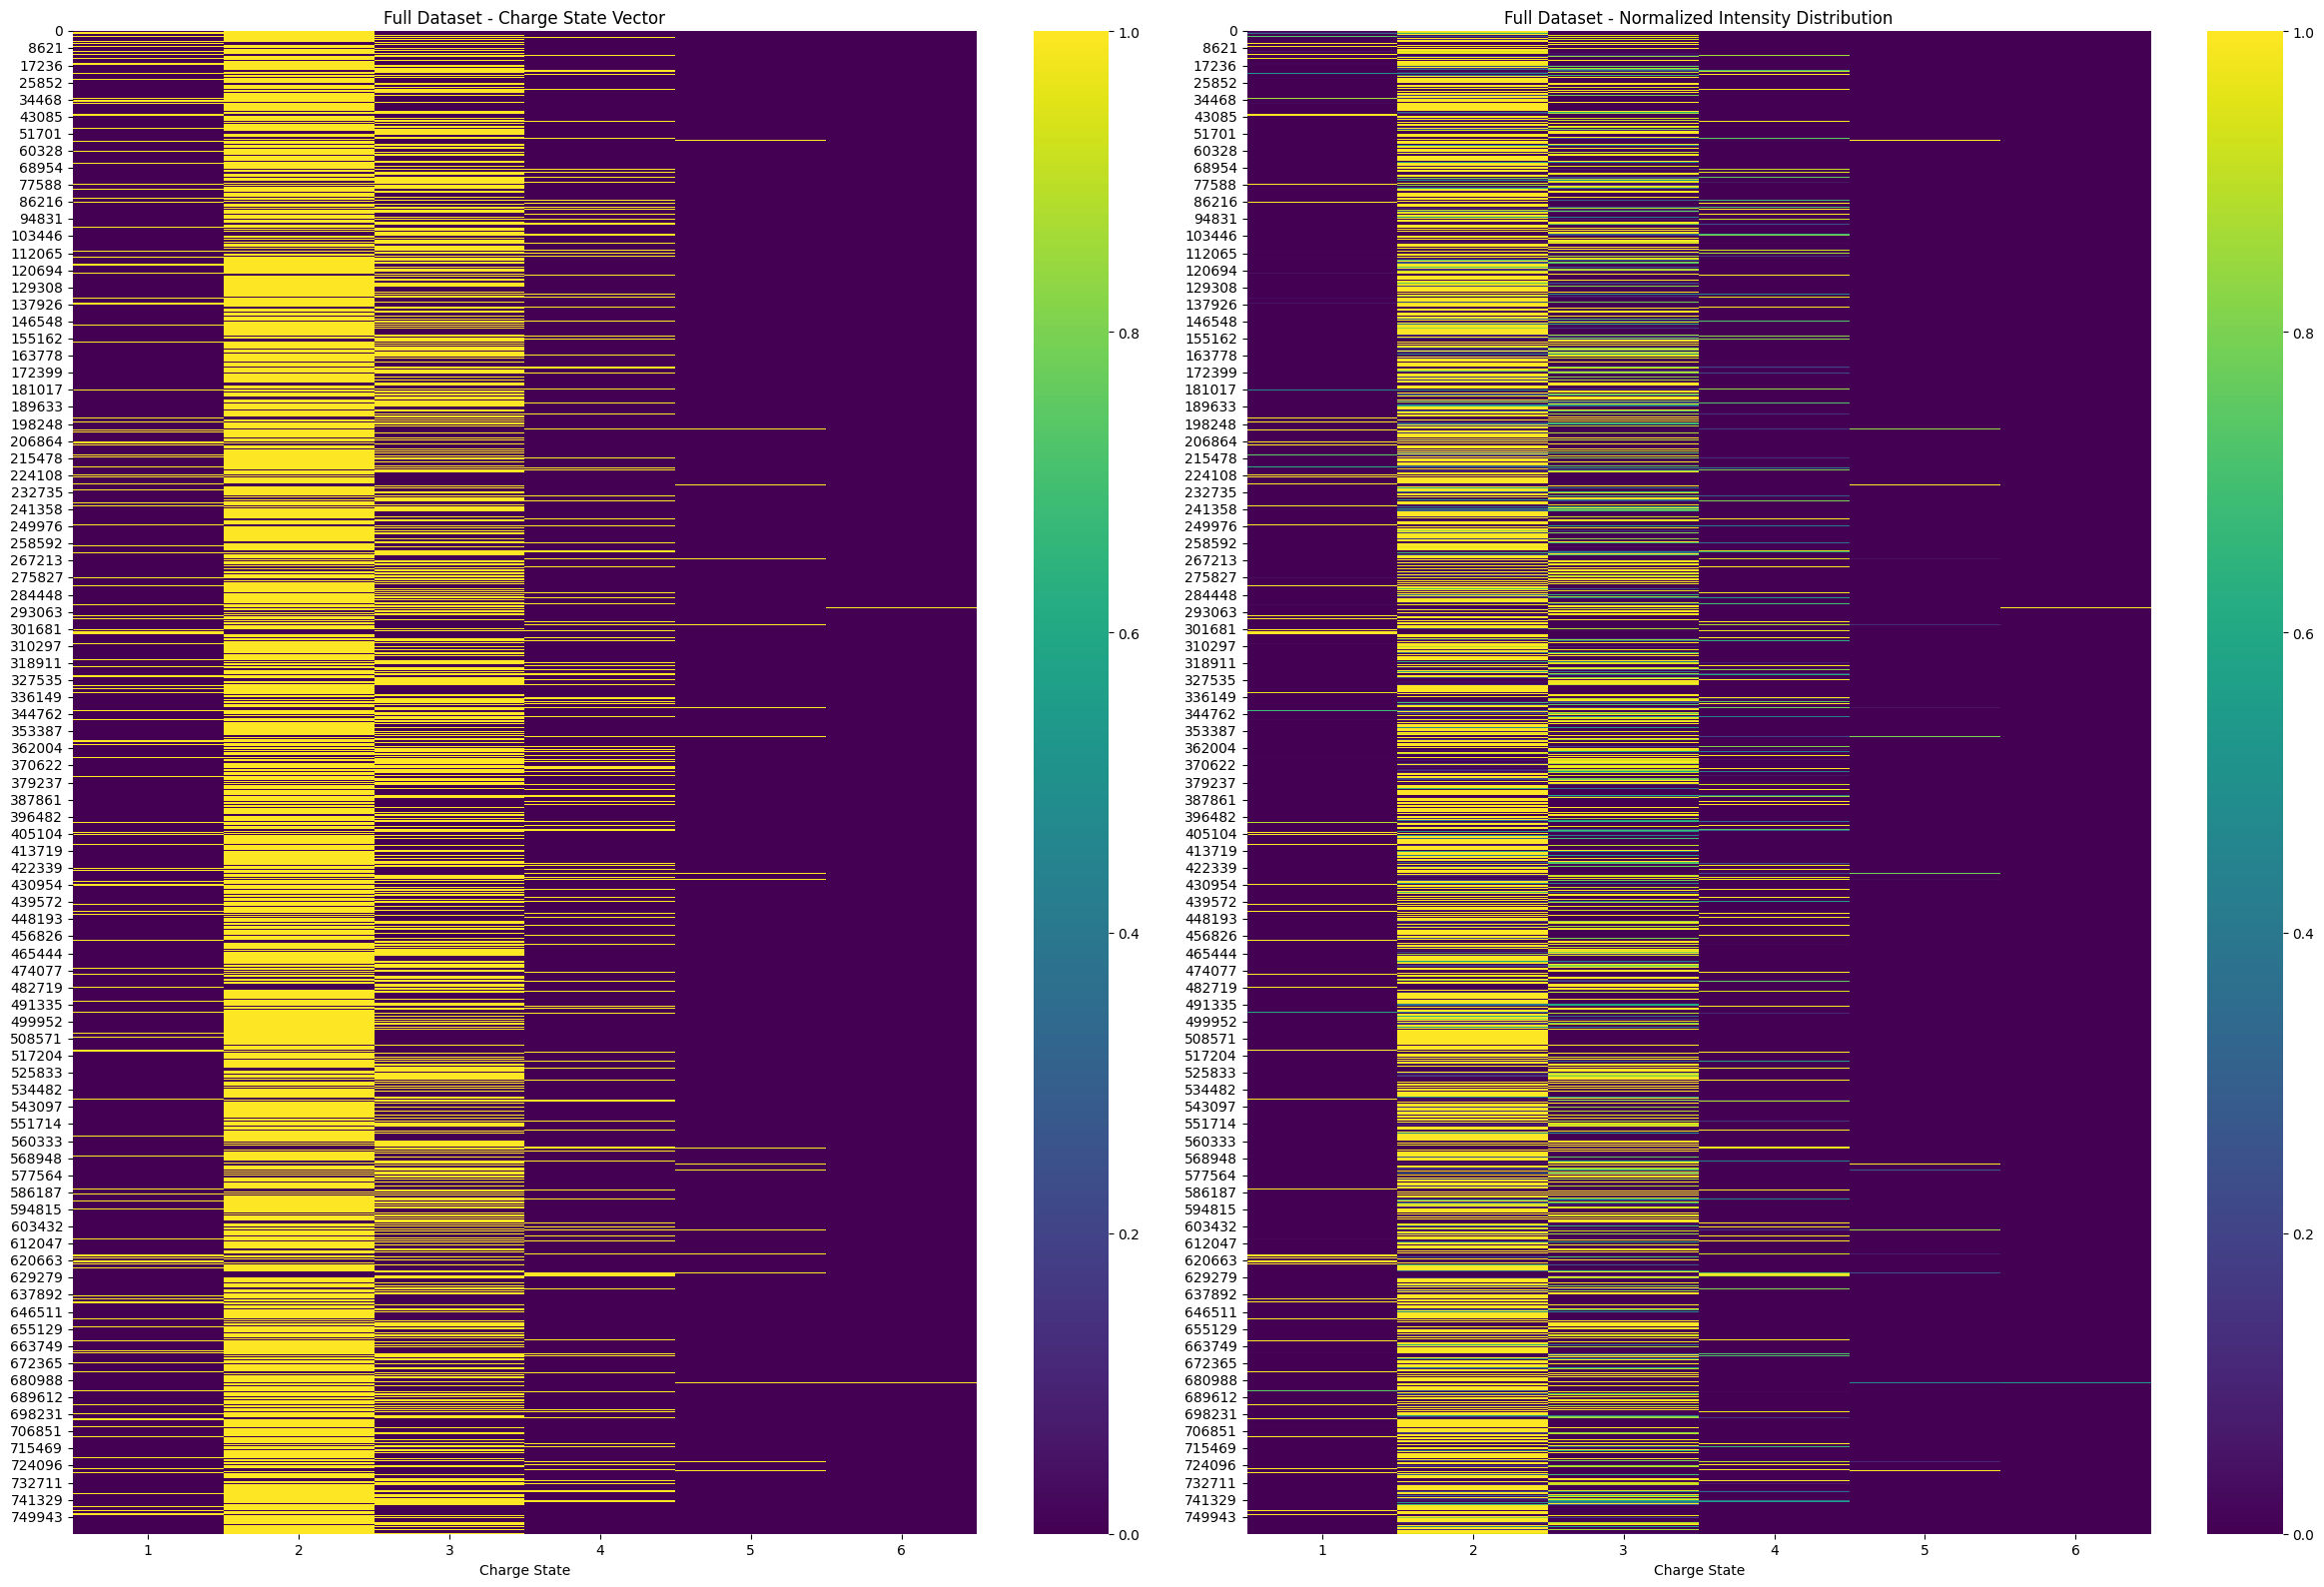

In [5]:
# Heatmap function for charge state vectors and intensity distributions
def plot_heatmaps(dataframe, title):
    charge_state_df = pd.DataFrame(dataframe['charge_state_vector'].tolist(), index=dataframe.index, columns=[f'{i}' for i in range(1, 7)])
    intensity_dist_df = pd.DataFrame(dataframe['normalized_intensity_distribution'].tolist(), index=dataframe.index, columns=[f'{i}' for i in range(1, 7)])

    plt.figure(figsize=(24, 16))
    plt.subplot(1, 2, 1)
    sns.heatmap(charge_state_df, cmap='viridis', cbar=True)
    plt.title(f'{title} - Charge State Vector')
    plt.xlabel('Charge State')

    plt.subplot(1, 2, 2)
    sns.heatmap(intensity_dist_df, cmap='viridis', cbar=True)
    plt.title(f'{title} - Normalized Intensity Distribution')
    plt.xlabel('Charge State')

    plt.tight_layout()
    plt.show()

plot_heatmaps(processed_data, "Full Dataset")

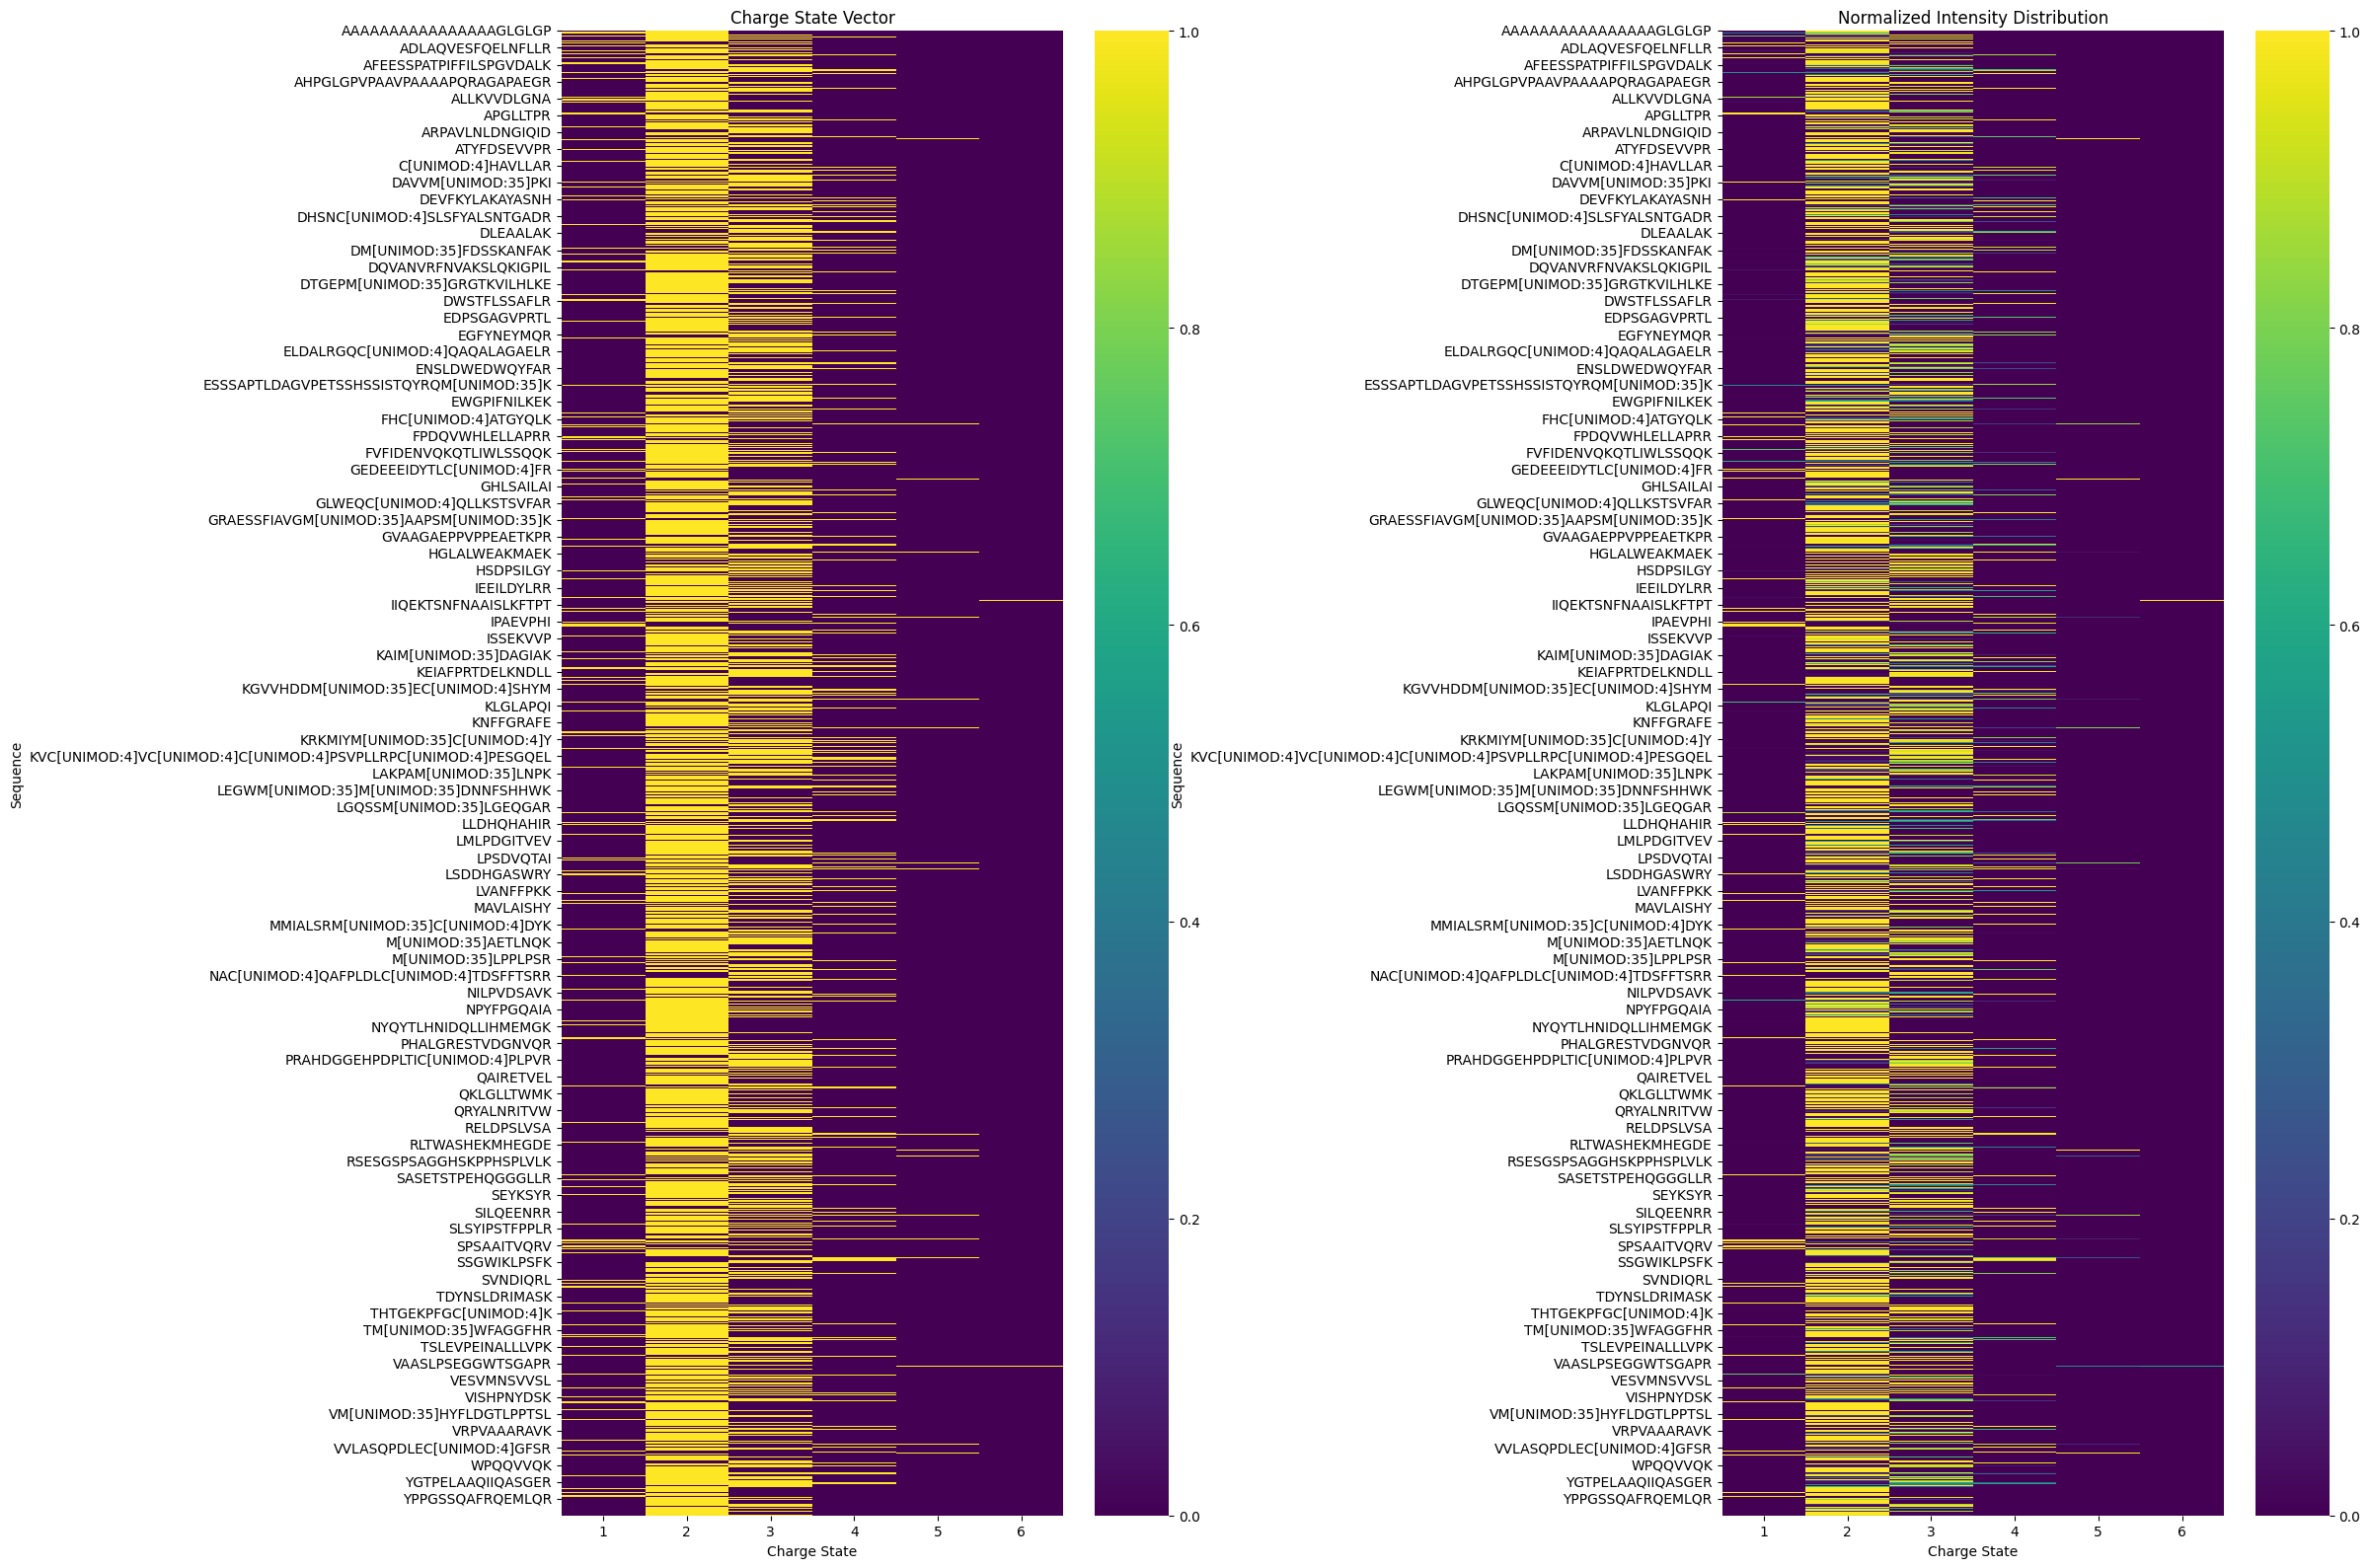

In [11]:
plot_df = processed_data.copy()

charge_state_df = pd.DataFrame(plot_df['charge_state_vector'].tolist(), index=plot_df['modified_sequence'], columns=[f'{i}' for i in range(1, 7)])
intensity_dist_df = pd.DataFrame(plot_df['normalized_intensity_distribution'].tolist(), index=plot_df['modified_sequence'], columns=[f'{i}' for i in range(1, 7)])

plt.figure(figsize=(24, 16))
plt.subplot(1, 2, 1)
sns.heatmap(charge_state_df, cmap='viridis', cbar=True)
plt.title('Charge State Vector')
plt.xlabel('Charge State')
plt.ylabel('Sequence')

plt.subplot(1, 2, 2)
sns.heatmap(intensity_dist_df, cmap='viridis', cbar=True)
plt.title('Normalized Intensity Distribution')
plt.xlabel('Charge State')
plt.ylabel('Sequence')

plt.tight_layout()
plt.show()

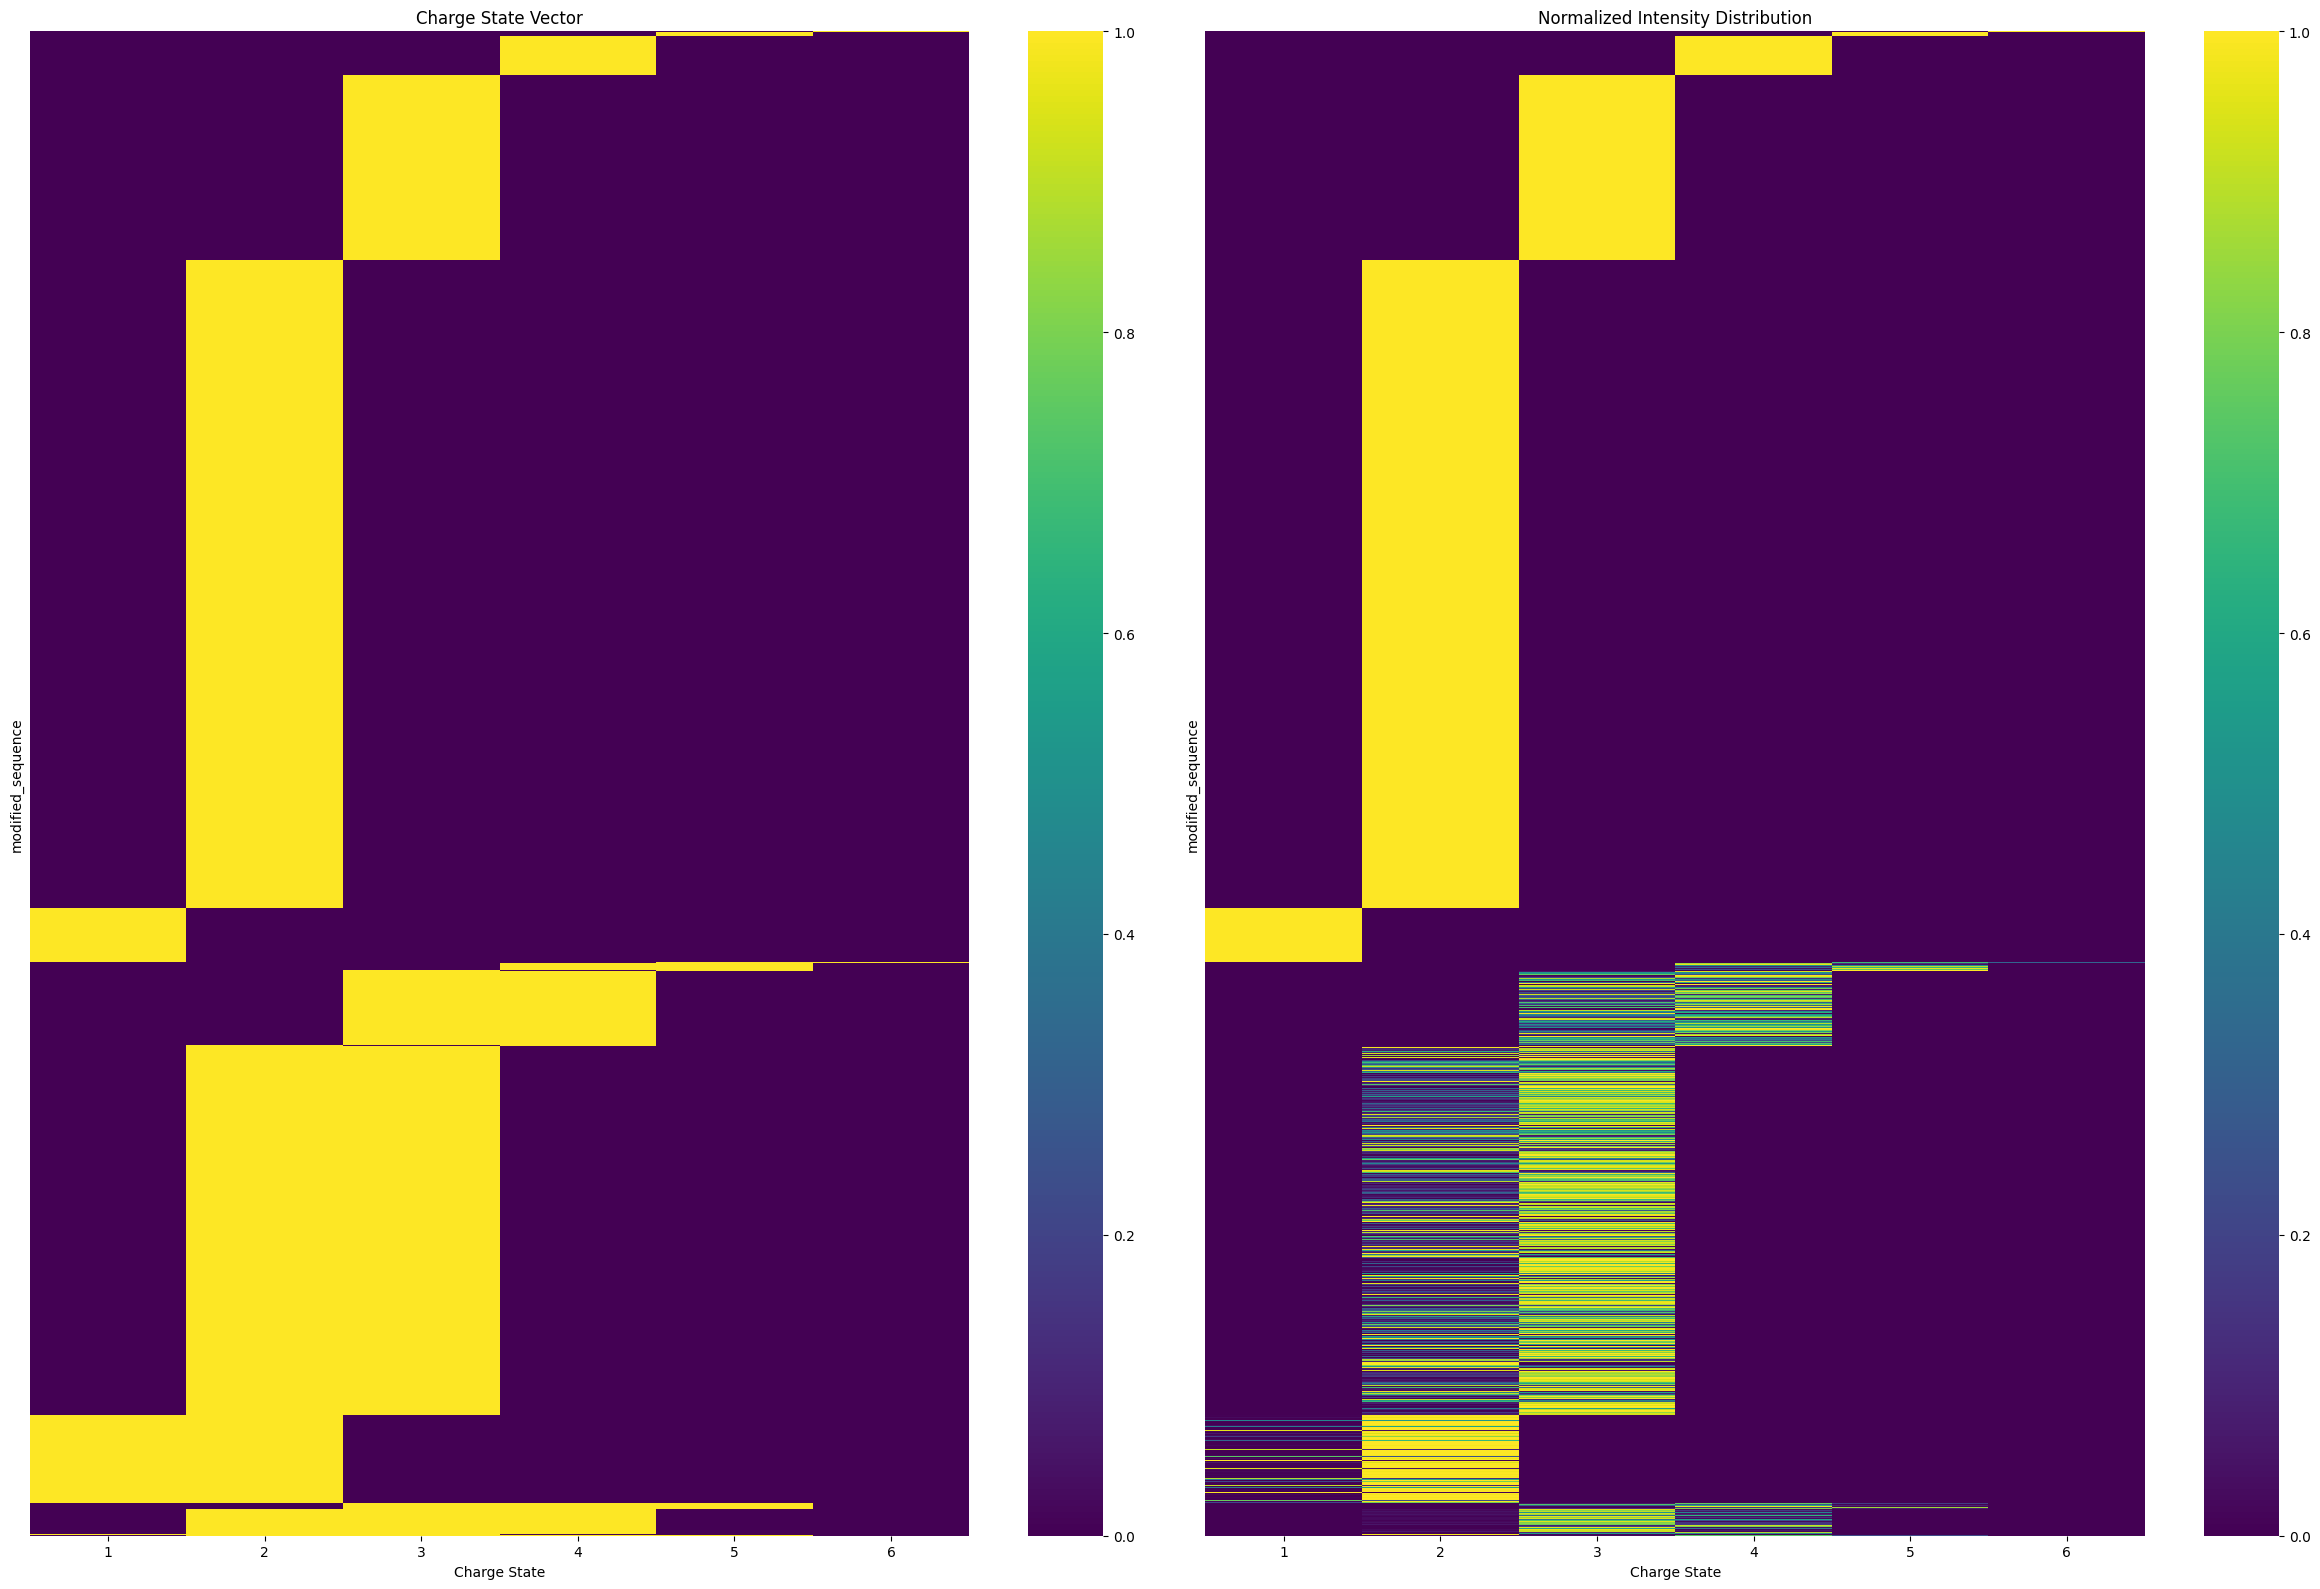

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plot_df = processed_data.copy()
charge_state_df = pd.DataFrame(plot_df['charge_state_vector'].tolist(), index=plot_df['modified_sequence'], columns=[f'{i}' for i in range(1, 7)])
intensity_dist_df = pd.DataFrame(plot_df['normalized_intensity_distribution'].tolist(), index=plot_df['modified_sequence'], columns=[f'{i}' for i in range(1, 7)])

# Function to sort charge state vectors
def sort_charge_state_vectors(row):
    values = row.values
    num_ones = sum(values)
    order = f"{num_ones:02d}" + "".join(map(str, values))
    return order

# Sort the DataFrames
sorted_indices = charge_state_df.apply(sort_charge_state_vectors, axis=1).sort_values().index
charge_state_df = charge_state_df.loc[sorted_indices]
intensity_dist_df = intensity_dist_df.loc[sorted_indices]

plt.figure(figsize=(24, 16))

# Plot charge state vector heatmap
plt.subplot(1, 2, 1)
sns.heatmap(charge_state_df, cmap='viridis', cbar=True, yticklabels=False)
plt.title('Charge State Vector')
plt.xlabel('Charge State')

# Plot normalized intensity distribution heatmap
plt.subplot(1, 2, 2)
sns.heatmap(intensity_dist_df, cmap='viridis', cbar=True, yticklabels=False)
plt.title('Normalized Intensity Distribution')
plt.xlabel('Charge State')

plt.tight_layout()
plt.show()

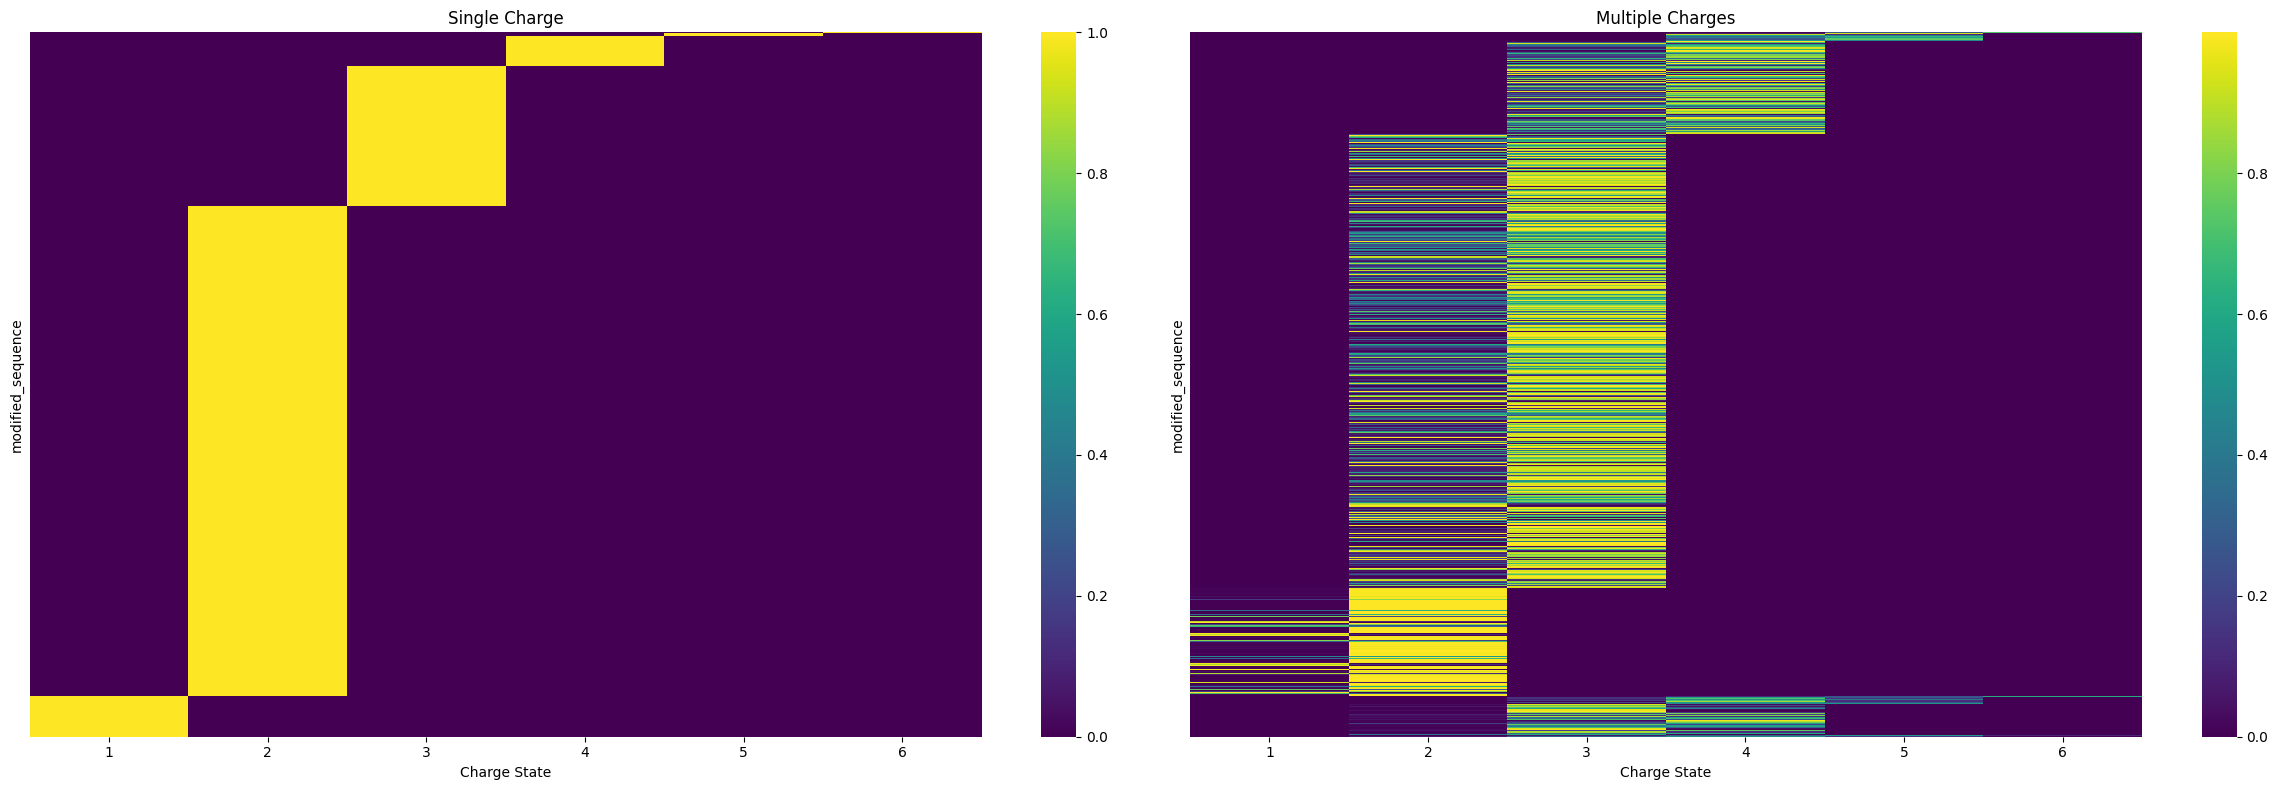

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_df = processed_data.copy()
charge_state_df = pd.DataFrame(plot_df['charge_state_vector'].tolist(), index=plot_df['modified_sequence'], columns=[f'{i}' for i in range(1, 7)])
intensity_dist_df = pd.DataFrame(plot_df['normalized_intensity_distribution'].tolist(), index=plot_df['modified_sequence'], columns=[f'{i}' for i in range(1, 7)])

# Function to sort charge state vectors
def sort_charge_state_vectors(row):
    values = row.values
    num_ones = int(sum(values))  # Convert to integer
    order = f"{num_ones:02d}" + "".join(map(str, map(int, values)))  # Convert values to integers
    return order

# Sort the DataFrames
sorted_indices = charge_state_df.apply(sort_charge_state_vectors, axis=1).sort_values().index
charge_state_df = charge_state_df.loc[sorted_indices]
intensity_dist_df = intensity_dist_df.loc[sorted_indices]

# Split into single and multiple charge DataFrames based on charge_state_df
single_charge_df = intensity_dist_df[charge_state_df.sum(axis=1) == 1]
multiple_charge_df = intensity_dist_df[charge_state_df.sum(axis=1) > 1]

plt.figure(figsize=(24, 8))

# Plot single charge heatmap
plt.subplot(1, 2, 1)
sns.heatmap(single_charge_df, cmap='viridis', cbar=True, yticklabels=False)
plt.title('Single Charge')
plt.xlabel('Charge State')

# Plot multiple charge heatmap
plt.subplot(1, 2, 2)
sns.heatmap(multiple_charge_df, cmap='viridis', cbar=True, yticklabels=False)
plt.title('Multiple Charges')
plt.xlabel('Charge State')

plt.tight_layout()
plt.show()

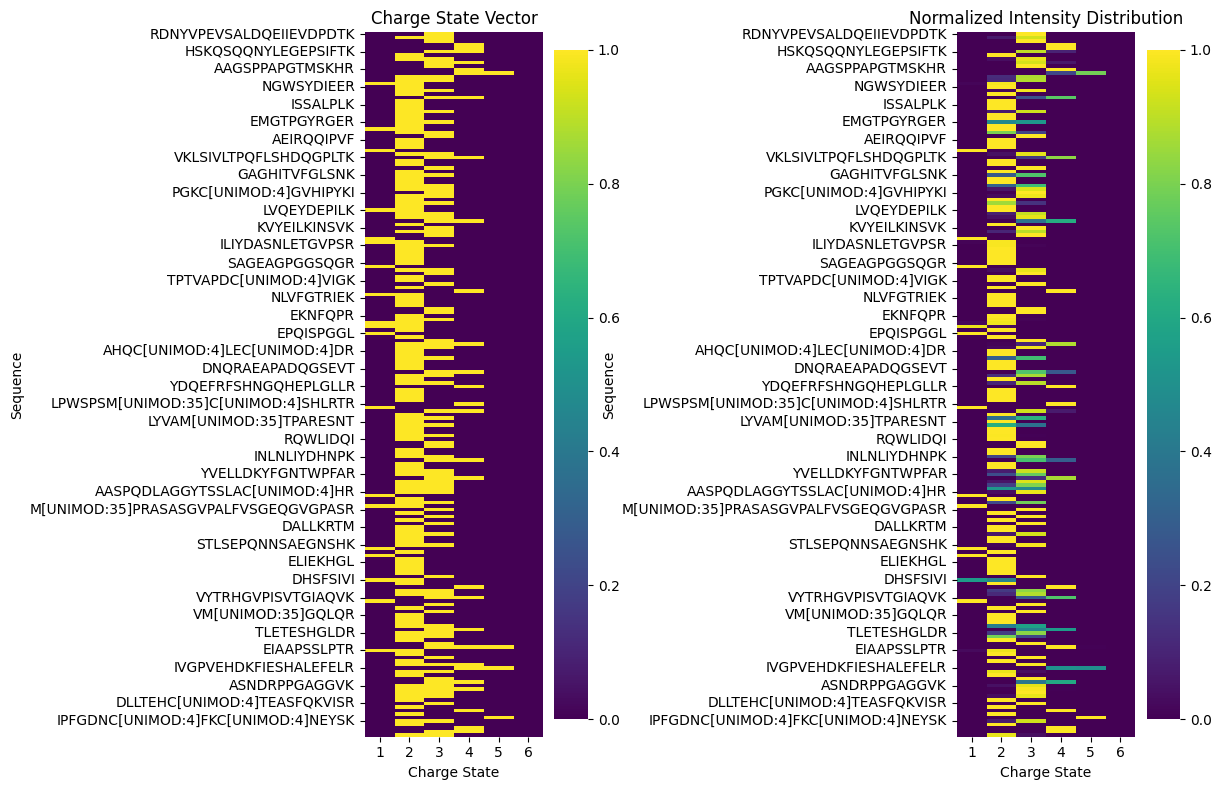

In [14]:
#Sampling some of the data
sampled_df = plot_df.sample(n=200, random_state=42)  

charge_state_sampled_df = pd.DataFrame(sampled_df['charge_state_vector'].tolist(), index=sampled_df['modified_sequence'], columns=[f'{i}' for i in range(1, 7)])
intensity_dist_sampled_df = pd.DataFrame(sampled_df['normalized_intensity_distribution'].tolist(), index=sampled_df['modified_sequence'], columns=[f'{i}' for i in range(1, 7)])


plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
sns.heatmap(charge_state_sampled_df, cmap='viridis', cbar=True)
plt.title('Charge State Vector')
plt.xlabel('Charge State')
plt.ylabel('Sequence')

plt.subplot(1, 2, 2)
sns.heatmap(intensity_dist_sampled_df, cmap='viridis', cbar=True)
plt.title('Normalized Intensity Distribution')
plt.xlabel('Charge State')
plt.ylabel('Sequence')

plt.tight_layout()
plt.show()

#### Idea: group by unique charge state vector
#### --> mean over each group

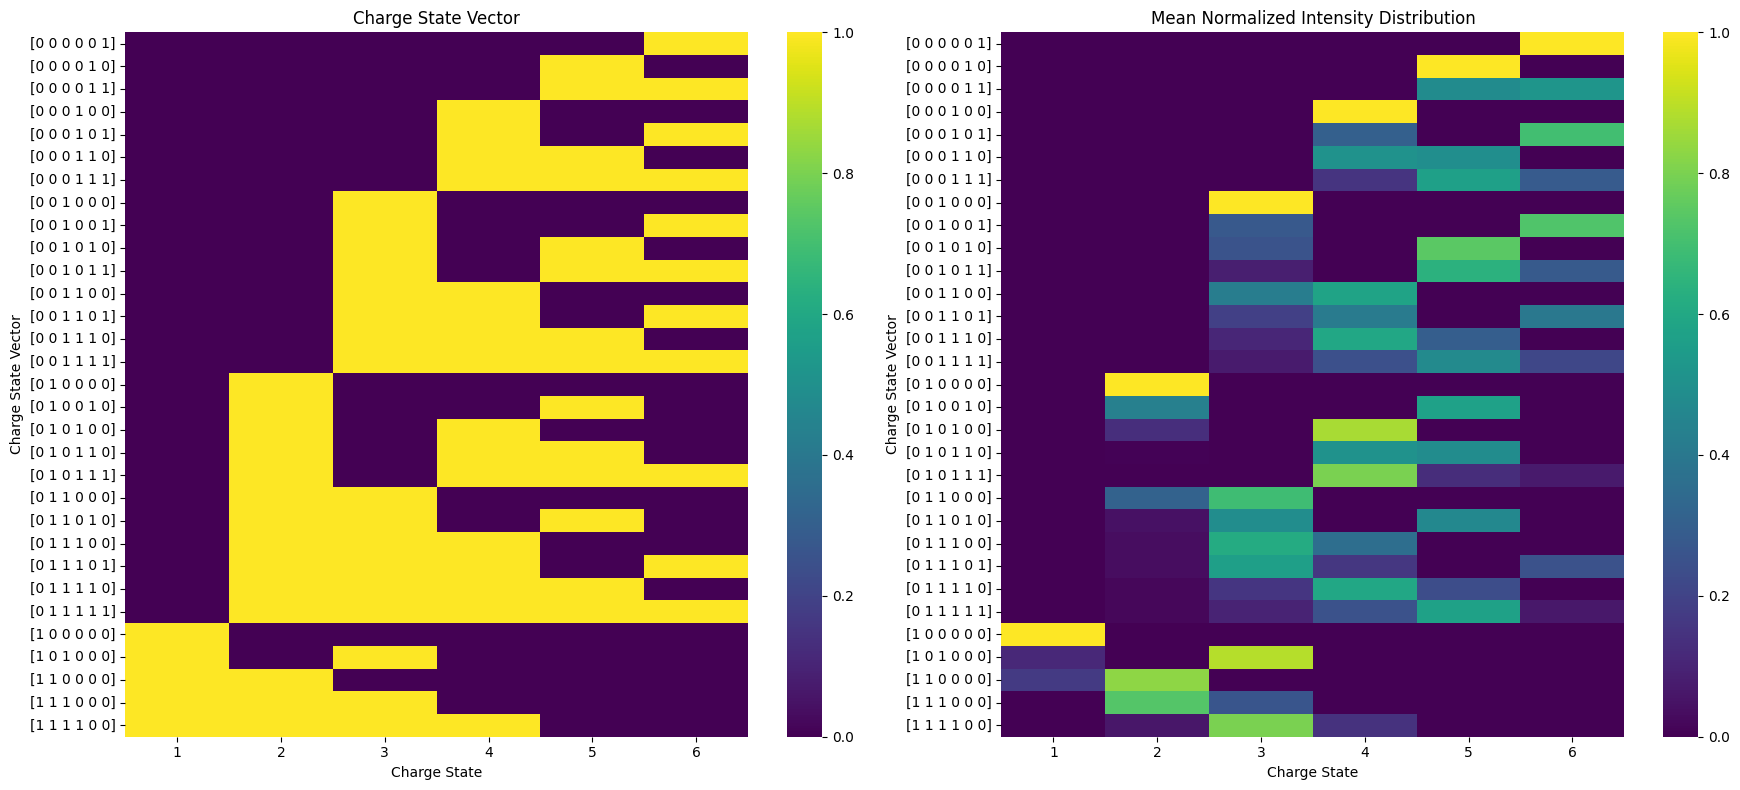

In [15]:
plot_df = processed_data.copy()
plot_df['charge_state_vector_str'] = plot_df['charge_state_vector'].apply(lambda x: str(x))

# Group by charge state vector string
grouped = plot_df.groupby('charge_state_vector_str')
# Calculate mean of normalized intensity distribution
agg_intensity_dist_df = grouped['normalized_intensity_distribution'].apply(lambda x: np.mean(np.vstack(x), axis=0)).reset_index(drop=True)

unique_charge_state_vectors = grouped['charge_state_vector'].first().apply(pd.Series).reset_index(drop=True)
unique_charge_state_vectors.columns = [i for i in range(1, 7)]
agg_intensity_dist_df = pd.DataFrame(agg_intensity_dist_df.tolist(), columns=[i for i in range(1, 7)])

# Charge state vectors as labels
ytick_labels = [str(vec) for vec in grouped['charge_state_vector'].first().index]

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.heatmap(unique_charge_state_vectors, cmap='viridis', cbar=True, yticklabels=ytick_labels)
plt.title('Charge State Vector')
plt.xlabel('Charge State')
plt.ylabel('Charge State Vector')

plt.subplot(1, 2, 2)
sns.heatmap(agg_intensity_dist_df, cmap='viridis', cbar=True, yticklabels=ytick_labels)
plt.title('Mean Normalized Intensity Distribution')
plt.xlabel('Charge State')
plt.ylabel('Charge State Vector')

plt.tight_layout()
plt.show()



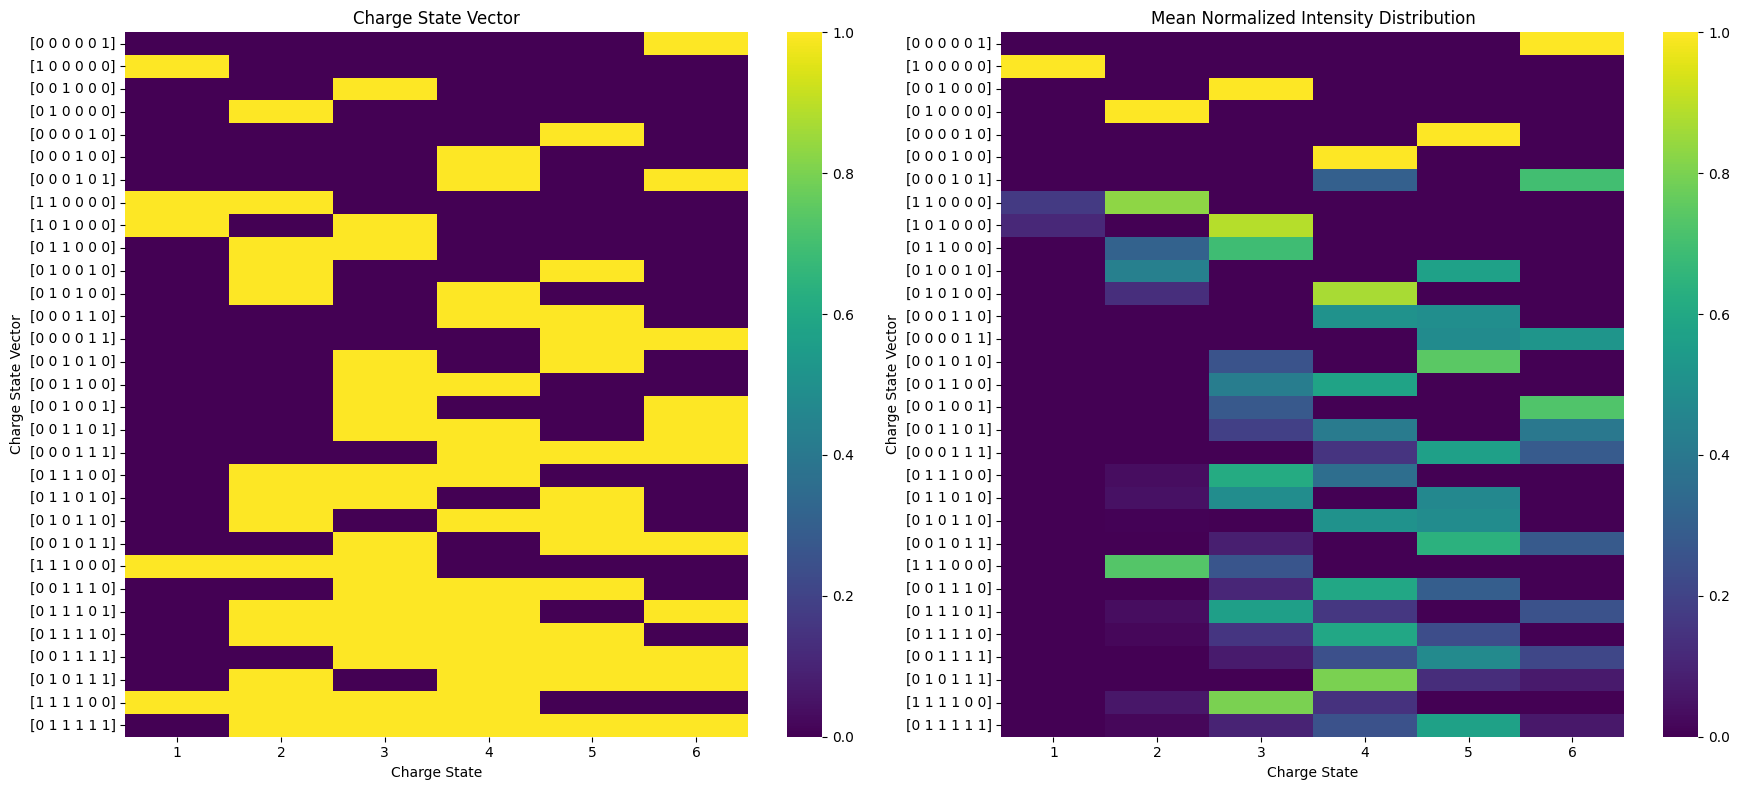

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming processed_data is already defined and populated
plot_df = processed_data.copy()
plot_df['charge_state_vector_str'] = plot_df['charge_state_vector'].apply(lambda x: str(x))

# Group by charge state vector string
grouped = plot_df.groupby('charge_state_vector_str')

# Calculate mean of normalized intensity distribution
agg_intensity_dist_df = grouped['normalized_intensity_distribution'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)).reset_index(drop=True)

# Extract unique charge state vectors
unique_charge_state_vectors = grouped['charge_state_vector'].first().apply(pd.Series).reset_index(drop=True)
unique_charge_state_vectors.columns = [i for i in range(1, 7)]

# Convert aggregated intensity distribution to DataFrame
agg_intensity_dist_df = pd.DataFrame(agg_intensity_dist_df.tolist(), columns=[i for i in range(1, 7)])

# Charge state vectors as labels
ytick_labels = [str(vec) for vec in grouped['charge_state_vector'].first().index]

# Add sum of charge state vector to sort
unique_charge_state_vectors['sum'] = unique_charge_state_vectors.sum(axis=1)
sorted_indices = unique_charge_state_vectors.sort_values(by='sum').index

# Sort dataframes and labels
unique_charge_state_vectors = unique_charge_state_vectors.loc[sorted_indices].drop(columns='sum')
agg_intensity_dist_df = agg_intensity_dist_df.loc[sorted_indices]
ytick_labels = [ytick_labels[i] for i in sorted_indices]

plt.figure(figsize=(18, 8))

# Plot charge state vector heatmap
plt.subplot(1, 2, 1)
sns.heatmap(unique_charge_state_vectors, cmap='viridis', cbar=True, yticklabels=ytick_labels)
plt.title('Charge State Vector')
plt.xlabel('Charge State')
plt.ylabel('Charge State Vector')

# Plot mean normalized intensity distribution heatmap
plt.subplot(1, 2, 2)
sns.heatmap(agg_intensity_dist_df, cmap='viridis', cbar=True, yticklabels=ytick_labels)
plt.title('Mean Normalized Intensity Distribution')
plt.xlabel('Charge State')
plt.ylabel('Charge State Vector')

plt.tight_layout()
plt.show()



### sorted

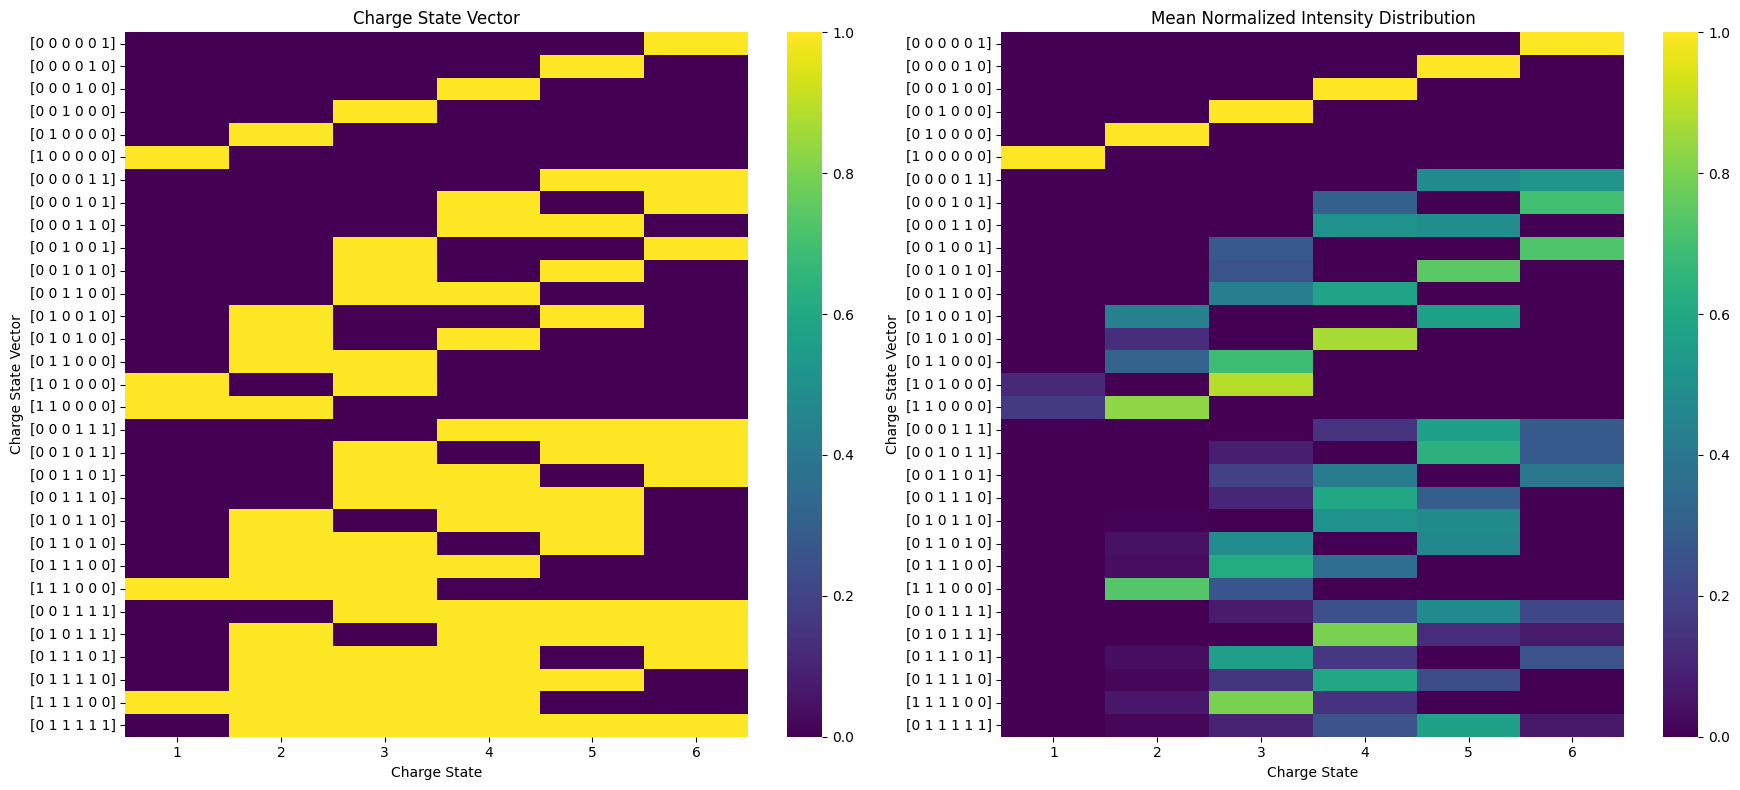

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming processed_data is already defined and populated
plot_df = processed_data.copy()
plot_df['charge_state_vector_str'] = plot_df['charge_state_vector'].apply(lambda x: str(x))

# Group by charge state vector string
grouped = plot_df.groupby('charge_state_vector_str')

# Calculate mean of normalized intensity distribution
agg_intensity_dist_df = grouped['normalized_intensity_distribution'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)).reset_index(drop=True)

# Extract unique charge state vectors
unique_charge_state_vectors = grouped['charge_state_vector'].first().apply(pd.Series).reset_index(drop=True)
unique_charge_state_vectors.columns = [i for i in range(1, 7)]

# Convert aggregated intensity distribution to DataFrame
agg_intensity_dist_df = pd.DataFrame(agg_intensity_dist_df.tolist(), columns=[i for i in range(1, 7)])

# Charge state vectors as labels
ytick_labels = [str(vec) for vec in grouped['charge_state_vector'].first().index]

# Function to sort charge state vectors
def sort_charge_state_vectors(row):
    values = row.values
    num_ones = sum(values)
    order = f"{num_ones:02d}" + "".join(map(str, values))
    return order

# Sort the DataFrames
sorted_indices = unique_charge_state_vectors.apply(sort_charge_state_vectors, axis=1).sort_values().index
unique_charge_state_vectors = unique_charge_state_vectors.loc[sorted_indices]
agg_intensity_dist_df = agg_intensity_dist_df.loc[sorted_indices]
ytick_labels = [ytick_labels[i] for i in sorted_indices]

plt.figure(figsize=(18, 8))

# Plot charge state vector heatmap
plt.subplot(1, 2, 1)
sns.heatmap(unique_charge_state_vectors, cmap='viridis', cbar=True, yticklabels=ytick_labels)
plt.title('Charge State Vector')
plt.xlabel('Charge State')
plt.ylabel('Charge State Vector')

# Plot mean normalized intensity distribution heatmap
plt.subplot(1, 2, 2)
sns.heatmap(agg_intensity_dist_df, cmap='viridis', cbar=True, yticklabels=ytick_labels)
plt.title('Mean Normalized Intensity Distribution')
plt.xlabel('Charge State')
plt.ylabel('Charge State Vector')

plt.tight_layout()
plt.show()